In [11]:


import io
import re
import math
from datetime import datetime as dt

import baltic as bt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import seaborn as sns

In [12]:
def kde_peak(data_1d):
    data = np.asarray(data_1d, dtype=float)
    data = data[np.isfinite(data)]
    if data.size == 0:
        return np.nan
    kde = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 500)
    return kde(xs).max()

def fracyear_to_datetime(fyear):
    year = int(fyear)
    remainder = float(fyear) - year
    days_in_year = 366 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 365
    return dt(year, 1, 1) + pd.to_timedelta(remainder * days_in_year, unit='D')

def hpd(data, alpha=0.05):
    d = np.sort(np.asarray(data))
    n = len(d)
    if n == 0:
        return np.nan, np.nan
    k = int(np.floor((1.0 - alpha) * n))
    if k < 1:
        return np.nan, np.nan
    intervals = d[k:] - d[:n - k]
    j = np.argmin(intervals)
    return float(d[j]), float(d[j + k])



In [13]:
def soft_rename(df):
    """Tolerate different column names from TreeAnnotator/Skygrid/Exp outputs."""
    cols = {c.lower(): c for c in df.columns}
    mapping = {
        "time":  ["time", "t", "x", "date_num", "decimal_time"],
        "mean":  ["mean", "median", "value", "ne_mean", "popsize", "popsize.mean"],
        "lower": ["lower", "hpd_lower", "hpdlow", "q2.5", "lower95", "lower95_hpd"],
        "upper": ["upper", "hpd_upper", "hpdup", "q97.5", "upper95", "upper95_hpd"],
    }
    for want, cands in mapping.items():
        if want not in df.columns:
            for c in cands:
                if c.lower() in cols:
                    df.rename(columns={cols[c.lower()]: want}, inplace=True)
                    break
    return df

def load_demo_table(path):
    """
    Load Skygrid/Exponential tables that may start with an un-commented title line.
    Finds the first line that contains the real header with: time, mean, lower, upper.
    """
    with open(path, 'r', encoding='utf-8', errors='ignore') as fh:
        lines = fh.readlines()

    header_idx = None
    for i, line in enumerate(lines):
        if not line.strip():
            continue
        cols = [c.strip().lower() for c in re.split(r'[\t,\s]+', line.strip()) if c.strip()]
        if {'time', 'mean', 'lower', 'upper'}.issubset(set(cols)):
            header_idx = i
            break

    # Fallback: assume second line is header if the first is a title
    if header_idx is None:
        header_idx = 1 if len(lines) > 1 else 0

    df = pd.read_csv(
        io.StringIO(''.join(lines[header_idx:])),
        sep=r'[\t\s]+', engine='python', comment="#"
    )
    df = soft_rename(df)

    need = {"time", "mean", "lower", "upper"}
    if not need.issubset(set(df.columns)):
        raise ValueError(f"{path} missing columns {need}; has {df.columns.tolist()}")

    # numeric + date
    for c in ["time", "mean", "lower", "upper"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df.dropna(subset=["time", "mean", "lower", "upper"], inplace=True)

    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        if df["date"].isna().all():
            df["date"] = df["time"].apply(fracyear_to_datetime)
    else:
        df["date"] = df["time"].apply(fracyear_to_datetime)

    return df

def load_dt_from_exp_log(path, burnin_frac=0.10, col_hint="exponential.growthRate"):
    """
    Read BEAST exponential coalescent log, apply burn-in, extract growthRate,
    keep positive rates only, and return doubling time (weeks).
    """
    df = pd.read_csv(path, sep="\t", comment="#", engine="python")
    df = df.iloc[int(len(df) * burnin_frac):].reset_index(drop=True)

    # locate growth-rate column
    if col_hint in df.columns:
        col = col_hint
    else:
        candidates = [c for c in df.columns
                      if c.endswith("growthRate") or c.lower().endswith("growthrate")]
        if not candidates:
            raise ValueError(f"No growthRate column in {path}. "
                             f"First columns: {df.columns.tolist()[:12]} ...")
        col = candidates[0]

    rates = pd.to_numeric(df[col], errors="coerce").to_numpy()
    pos = np.isfinite(rates) & (rates > 0)
    if not np.any(pos):
        raise ValueError("No positive growth rates after burn-in; cannot compute doubling time.")

    dt_weeks = (np.log(2) / rates[pos]) * 52.0  # convert years -> weeks
    return dt_weeks

In [14]:
TREE    = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Mask+SLE+Artic+25sept17/CladeiiB+SLE.mcc.tree"
LOG     = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Mask+SLE+Artic+25sept17/ALL+SLE+Cladeiib+25sept17.log"
SKYGRID = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Mask+SLE+Artic+25sept17/SKD.txt"
EXPO    = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Mask+SLE+Artic+25sept17/EXP.txt"
EXPLOG  = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Mask+SLE+Artic+25sept17/ALL+SLE+Cladeiib+25sept17.log"

OUT_BASENAME = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Mask+SLE+Artic+25sept17/Figure2+Panel"

min_year, max_year = 2015, 2026   # x-range for tree/densities
panel_label_size   = 45


In [15]:
T = bt.loadNexus(
    TREE,
    tip_regex=r"\|(\d{4}(?:-\d{2})?(?:-\d{2})?)$",
    absoluteTime=True
)
T.treeStats()
ymax = T.ySpan

# Load BEAST log 
log_df = pd.read_csv(LOG, delim_whitespace=True, comment="#", engine="python")

# Ensure columns exist
need_ages = ["age(SLE)", "age(stemSLE)"]
missing = [c for c in need_ages if c not in log_df.columns]
if missing:
    raise ValueError(f"Missing expected columns in log: {missing}. "
                     f"Present: {list(log_df.columns)[:10]} ...")

peak_frac = 0.20
xs_dec = np.linspace(min_year, max_year, 500)

kde_sle  = gaussian_kde(log_df["age(SLE)"])
kde_stem = gaussian_kde(log_df["age(stemSLE)"])

peak_sle  = kde_peak(log_df["age(SLE)"])
peak_stem = kde_peak(log_df["age(stemSLE)"])

scale_sle  = (ymax * peak_frac) / peak_sle  if (isinstance(peak_sle, float) and peak_sle > 0) else 1.0
scale_stem = (ymax * peak_frac) / peak_stem if (isinstance(peak_stem, float) and peak_stem > 0) else 1.0

ys_sle  = kde_sle(xs_dec)  * scale_sle
ys_stem = kde_stem(xs_dec) * scale_stem

col_dict = {
    'SLE':  '#9A031E',
    'Nigeria': '#E36414',
    'Congo':  '#A412FF',
    'Togo':   '#ff12ac',
    'Ghana':  '#003566',
    'Germany':'#219EBC',
    'USA':    '#007F5F',
    'Guinea': '#90BE6D',
    'Rest':   'black'
}
label_map = {
    'SLE': 'Sierra Leone', 'Nigeria': 'Nigeria', 'Togo': 'Togo',
    'Ghana': 'Ghana', 'Germany': 'Germany', 'USA': 'USA',
    'Guinea': 'Guinea', 'Rest': 'Rest', 'Congo': "Congo", 'Unknown': 'Unknown'
}
c_func = lambda k: col_dict.get(k.name.split('|')[-2], col_dict['Rest'])


Tree height: 9.434859
Tree length: 218.462429
strictly bifurcating tree

Numbers of objects in tree: 1057 (528 nodes and 529 leaves)



/var/folders/xt/vz8fznds4hdbfcxyds95mtp00000gp/T/ipykernel_79333/1460268128.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  log_df = pd.read_csv(LOG, delim_whitespace=True, comment="#", engine="python")


In [16]:


# --------------------------
# B) Demographic model (Skygrid vs Exponential)
# --------------------------
sky = load_demo_table(SKYGRID)
exp = load_demo_table(EXPO)

# y-lims from credible bounds (ensure a small positive floor for log scale)
ymax_dem = float(max(exp["upper"].max(), sky["upper"].max()))
ymin_dem = float(min(exp["lower"].min(), sky["lower"].min()))
ymin_safe = max(ymin_dem * 0.8, 1e-9)

# x-lims from data extents (try fixed window; else fall back to data)
xmin_data = min(sky["date"].min(), exp["date"].min())
xmax_data = max(sky["date"].max(), exp["date"].max())

fixed_xmin = pd.to_datetime('2024-11-30')
fixed_xmax = pd.to_datetime('2025-08-08')
use_fixed_window = (fixed_xmin >= xmin_data) and (fixed_xmax <= xmax_data)



In [17]:
# --------------------------
# C) Doubling time (weeks) from Only+SLE+Exp.log
# --------------------------
dt_vals = load_dt_from_exp_log(EXPLOG, burnin_frac=0.10, col_hint="expSLE.growthRate")
mean_dt  = float(np.mean(dt_vals))
hpd_lo, hpd_hi = hpd(dt_vals, alpha=0.05)
x99 = float(np.nanquantile(dt_vals, 0.99))

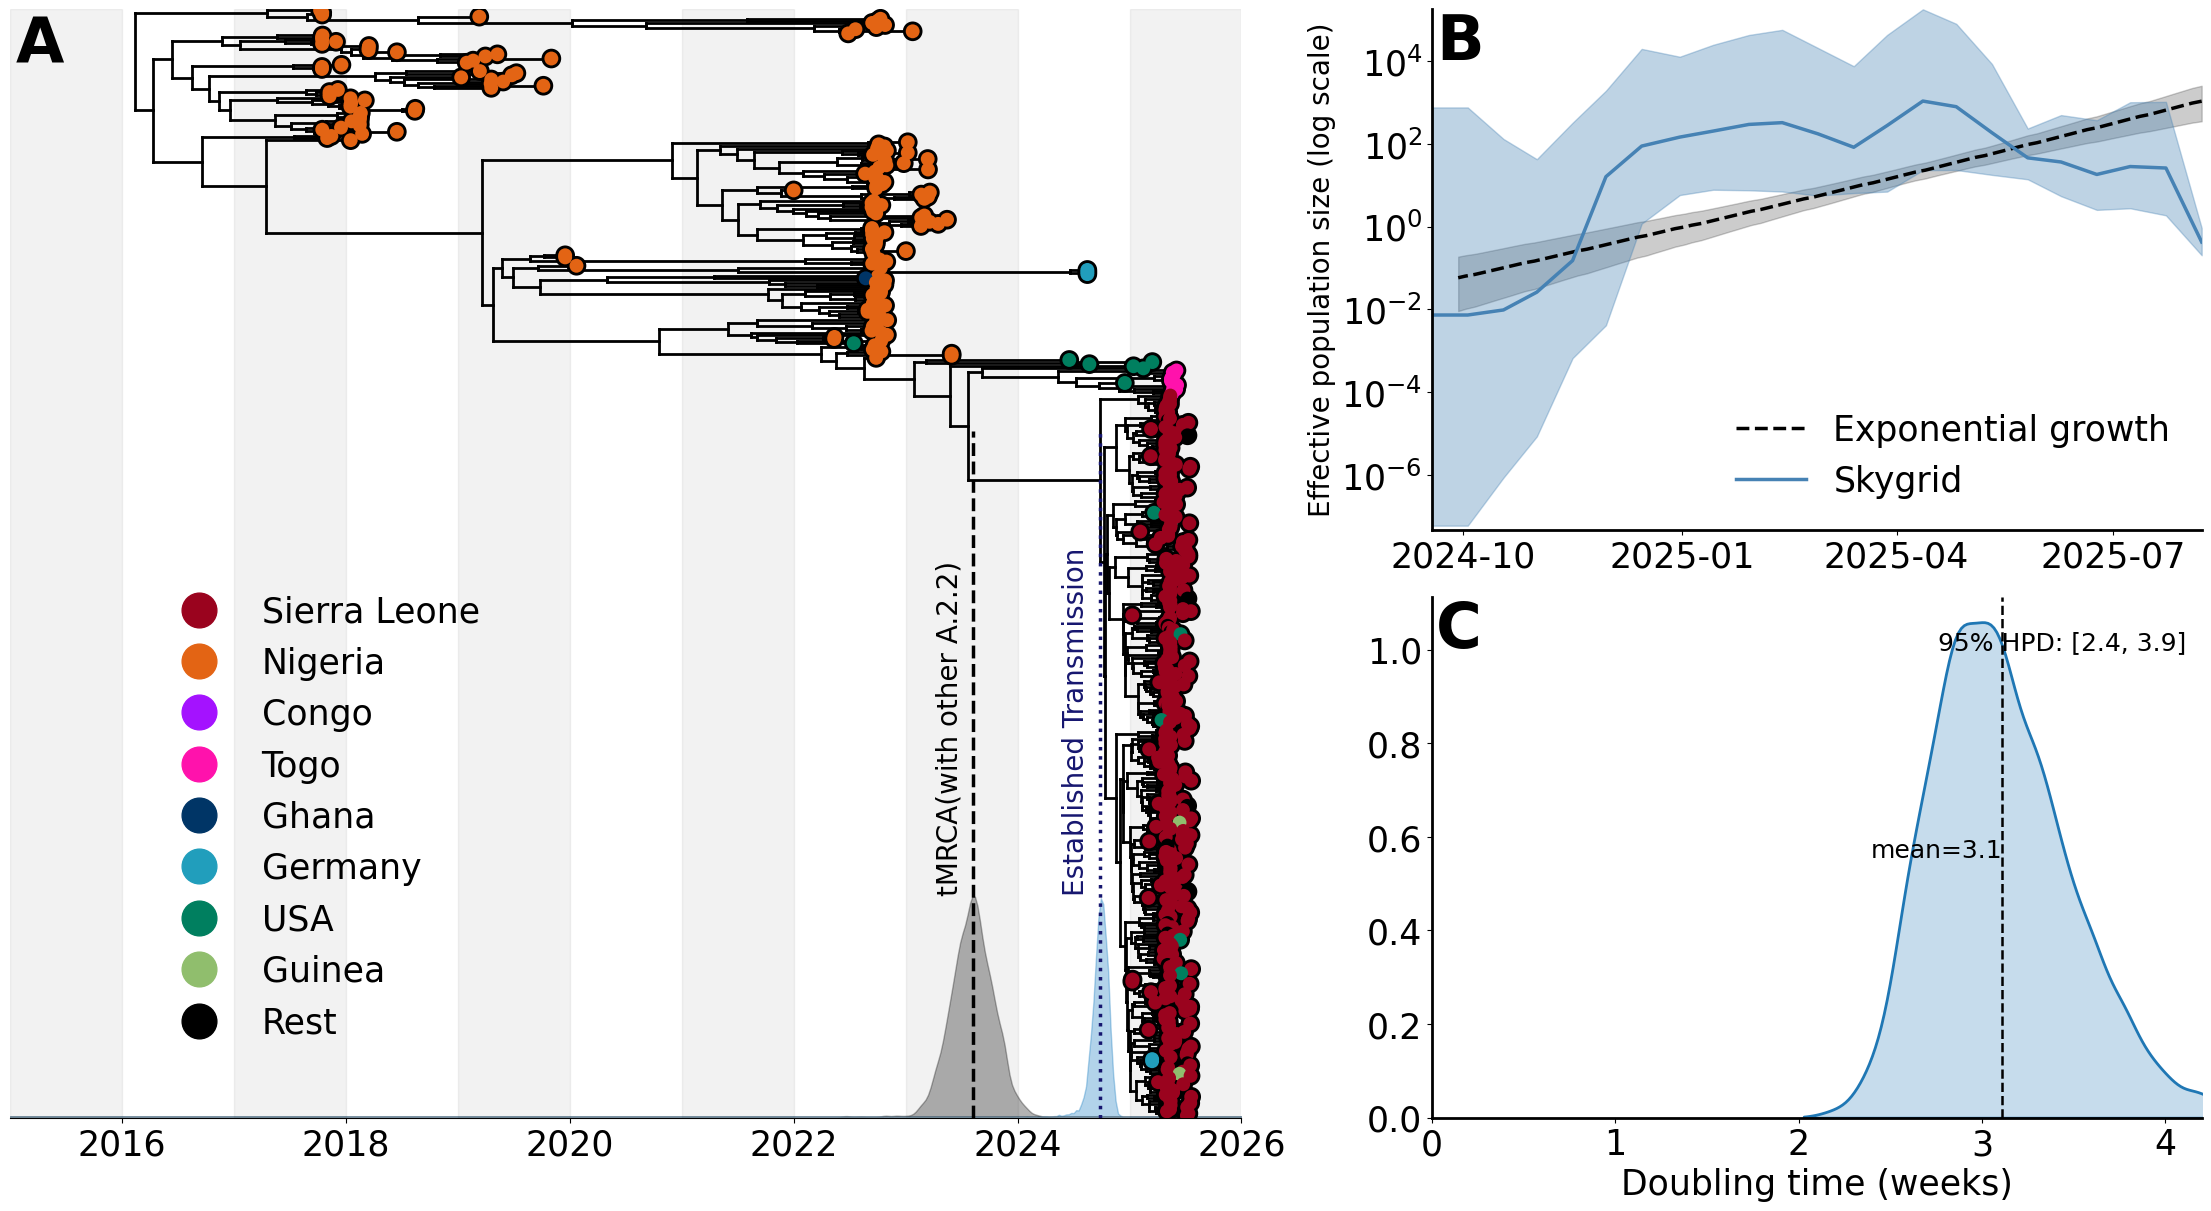

In [18]:


# --------------------------
# LAYOUT: A left (full height), B top-right, C bottom-right
# --------------------------
fig = plt.figure(figsize=(22, 12), facecolor='w', constrained_layout=True)
gs  = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1.6, 1.0], height_ratios=[1, 1])

axA = fig.add_subplot(gs[:, 0])  # A: tree (spans both rows on the left)
axB = fig.add_subplot(gs[0, 1])  # B: demographic (top-right)
axC = fig.add_subplot(gs[1, 1])  # C: doubling time (bottom-right)

# ---------- Plot A: Tree + densities ----------
for i, yr in enumerate(range(min_year, max_year)):
    if i % 2 == 0:
        axA.axvspan(yr, yr + 1, color='k', alpha=0.05, zorder=0)

axA.fill_between(xs_dec, 0, ys_sle,  color='#0070BB',   alpha=0.30, zorder=1, label='age(SLE) density')
axA.fill_between(xs_dec, 0, ys_stem, color='black', alpha=0.30, zorder=1, label='age(stemSLE) density')

T.plotTree(axA,   x_attr=lambda k: k.absoluteTime, zorder=2)
T.plotPoints(axA, size=lambda k: 100, colour=c_func, x_attr=lambda k: k.absoluteTime, zorder=3)

for x_val, txt, ls, col in [
    (2024.74, "Established Transmission", ":", "#16166F"),
    (2023.606,  "tMRCA(with other A.2.2)",       "--", "black")
]:
    axA.axvline(x_val, ymin=0, ymax=0.62, linestyle=ls, linewidth=2.5, color=col, zorder=4)
    axA.text(x_val - 0.09, ymax * 0.2, txt, fontsize=20, rotation=90,
             va='bottom', ha='right', color=col, zorder=4)

legend_handles = [
    mlines.Line2D([], [], color=col, marker='o', markersize=25,
                  linestyle='None', label=label_map.get(key, key))
    for key, col in col_dict.items()
]
leg = axA.legend(handles=legend_handles, ncol=1, frameon=False,
                 loc='upper left', bbox_to_anchor=(0.1, 0.5), prop={'size': 25})
leg.set_zorder(5)


axA.set_xlim(min_year, max_year)
axA.set_ylim(-0.5, ymax)
axA.tick_params(axis='y', left=False, labelleft=False)
axA.tick_params(axis='x', labelsize=25)
for s in ['top', 'right', 'left']:
    axA.spines[s].set_visible(False)
axA.set_xlabel("", fontsize=25)
axA.text(0.005, 0.995, "A", transform=axA.transAxes, ha='left', va='top',
         fontsize=panel_label_size, weight='bold')

# ---------- Plot B: Demographic (Skygrid vs Exponential, log y) ----------
axB.plot(exp["date"], exp["mean"], linestyle='--', linewidth=2.5, label="Exponential growth", color='k')
axB.fill_between(exp["date"], exp["lower"], exp["upper"], alpha=0.20, color='k')

axB.plot(sky["date"], sky["mean"], linewidth=2.5, label="Skygrid", color="#4682B4")
axB.fill_between(sky["date"], sky["lower"], sky["upper"], alpha=0.35, color="#4682B4")

axB.set_yscale("log")
axB.set_ylim(ymin_safe, ymax_dem)

if use_fixed_window:
    axB.set_xlim(fixed_xmin, fixed_xmax)
else:
    axB.set_xlim(xmin_data, xmax_data)

axB.set_ylabel("Effective population size (log scale)", fontsize=20)
axB.set_xlabel("")
axB.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axB.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axB.tick_params(axis='x', rotation=0, labelsize=25)
axB.tick_params(axis='y', labelsize=25)

for s in ['top', 'right']:
    axB.spines[s].set_visible(False)
axB.spines['bottom'].set_linewidth(2)
axB.spines['left'].set_linewidth(2)
axB.legend(frameon=False, loc="lower right", fontsize=25)

axB.text(0.005, 0.995, "B", transform=axB.transAxes, ha='left', va='top',
         fontsize=panel_label_size, weight='bold')

# ---------- Plot C: Doubling time KDE ----------
sns.kdeplot(x=dt_vals, cut=0, fill=True, linewidth=2, label="Doubling time", ax=axC)
axC.set_xlim(0, x99)
axC.set_xlabel("Doubling time (weeks)", fontsize=25)
axC.set_ylabel("", fontsize=0)
axC.tick_params(axis='x', labelsize=25)
axC.tick_params(axis='y', labelsize=25)

for s in ['top', 'right']:
    axC.spines[s].set_visible(False)
for s in axC.spines.values():
    s.set_linewidth(2)

axC.axvline(mean_dt, color='k', linestyle='--', linewidth=1.8)
axC.text(mean_dt, axC.get_ylim()[1]*0.5, f"mean={mean_dt:.1f}", ha='right', fontsize=18)
axC.text(0.98, 0.90, f"95% HPD: [{hpd_lo:.1f}, {hpd_hi:.1f}]",
         transform=axC.transAxes, ha='right', fontsize=18)

axC.text(0.005, 0.995, "C", transform=axC.transAxes, ha='left', va='top',
         fontsize=panel_label_size, weight='bold')

# --------------------------
# Save / Show
# --------------------------
#fig.savefig(f"{OUT_BASENAME}.png", dpi=300, bbox_inches='tight')
#fig.savefig(f"{OUT_BASENAME}.pdf", dpi=300, bbox_inches='tight')
#fig.savefig(f"{OUT_BASENAME}.svg", dpi=300, bbox_inches='tight')
plt.show()
